In [152]:
import psycopg2
import pandas as pd
from matplotlib import pyplot as plt 
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
import numpy as np

pg_connection = psycopg2.connect(
    database="fubon", 
    user="postgres", 
    password="postgres", 
    host="192.168.1.107", 
    port="5432"
)

with pg_connection.cursor() as cursor:
    cursor.execute(query=
        """
            SELECT 
                symbol, 
                date, 
                open, 
                close, 
                low, 
                high, 
                volume
            FROM public.ticker_daily_trading_histories
            WHERE symbol = '2887'
            ORDER BY date
        """
    )
    
    df = pd.DataFrame(
        cursor.fetchall(),
        columns = ['symbol', 'date', 'open', 'close', 'low', 'high', 'volume']
    )
    # print(df)

# print(df.columns)
# print(df.values)

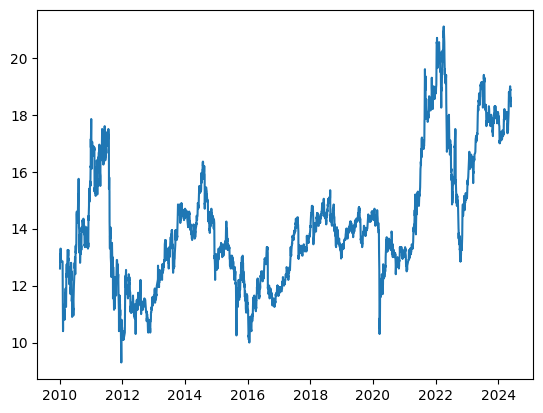

In [153]:
# Function to plot 
plt.plot(
    df['date'].values, 
    df['close'].values
) 

# function to show the plot 
plt.show()

In [154]:
train_count = int(df.shape[0]*0.8)
# train_df = df.iloc[:train_count]
train_df = df.iloc[:]
test_df = df.iloc[train_count:]

In [155]:
def min_max_normalize(dimension):
    #調整維度成[[資料1],[資料2]]
    dimension = dimension.reshape(-1, 1)
    #正規化數值
    scaler = MinMaxScaler(feature_range=(0, 1)).fit(dimension)
    sc = scaler.transform(dimension)
    
    #[維度還原]
    return sc.reshape(-1)

normalized_train_open  = min_max_normalize(train_df['open'].values)
normalized_train_close = min_max_normalize(train_df['close'].values)
normalized_train_low = min_max_normalize(train_df['low'].values)
normalized_train_high = min_max_normalize(train_df['high'].values)
normalized_train_volume = min_max_normalize(train_df['volume'].values)

normalized_test_open  = min_max_normalize(test_df['open'].values)
normalized_test_close = min_max_normalize(test_df['close'].values)
normalized_test_low = min_max_normalize(test_df['low'].values)
normalized_test_high = min_max_normalize(test_df['high'].values)
normalized_test_volume = min_max_normalize(test_df['volume'].values)

In [156]:
n_days = 5
train_data = []
train_labels = []

for i in range(n_days, len(normalized_train_volume)):
    normalized_open_n_days = normalized_train_open[i-n_days:i]
    normalized_close_n_days = normalized_train_close[i-n_days:i]
    normalized_low_n_days = normalized_train_low[i-n_days:i]
    normalized_high_n_days = normalized_train_high[i-n_days:i]
    normalized_volume_n_days = normalized_train_volume[i-n_days:i]
    
    # print(normalized_open_n_days)

    data_n_days = []

    for open, close, low, high, volume in zip(
        normalized_open_n_days,
        normalized_close_n_days,
        normalized_low_n_days,
        normalized_high_n_days,
        normalized_volume_n_days
    ):
        data_n_days.append([open, close, low, high, volume])

    train_data.append(data_n_days)
    data_n_days = []
    
    train_labels.append(normalized_train_close[i:i+1][0])

In [157]:
test_data = []
test_labels = []

for i in range(n_days, len(normalized_test_volume)):
    normalized_open_n_days = normalized_test_open[i-n_days:i]
    normalized_close_n_days = normalized_test_close[i-n_days:i]
    normalized_low_n_days = normalized_test_low[i-n_days:i]
    normalized_high_n_days = normalized_test_high[i-n_days:i]
    normalized_volume_n_days = normalized_test_volume[i-n_days:i]
    
    # print(normalized_open_n_days)

    data_n_days = []

    for open, close, low, high, volume in zip(
        normalized_open_n_days,
        normalized_close_n_days,
        normalized_low_n_days,
        normalized_high_n_days,
        normalized_volume_n_days
    ):
        data_n_days.append([open, close, low, high, volume])

    test_data.append(data_n_days)
    data_n_days = []
    
    test_labels.append(normalized_test_close[i:i+1][0])

In [158]:
x_train,y_train = np.array(train_data),np.array(train_labels)
x_test,y_test = np.array(test_data),np.array(test_labels)

In [159]:
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(128,input_shape=(n_days, 5),return_sequences=True,activation='relu'),
    tf.keras.layers.LSTM(64,return_sequences=False,activation='relu'),
    tf.keras.layers.Dense(1)
])

model.compile(
    loss='mean_squared_error',
    optimizer='adam'
)

history = model.fit(
    x_train, 
    y_train,
    batch_size=64,
    epochs=20,
    verbose=1,
    validation_data=(x_test, y_test)
)

/home/vscode/.local/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 10s 40ms/step - loss: 0.0979 - val_loss: 0.0039
Epoch 2/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0013 - val_loss: 0.0026
Epoch 3/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 7.8841e-04 - val_loss: 0.0023
Epoch 4/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 8.5644e-04 - val_loss: 0.0022
Epoch 5/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 7.5522e-04 - val_loss: 0.0024
Epoch 6/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 6.8068e-04 - val_loss: 0.0024
Epoch 7/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 6.3301e-04 - val_loss: 0.0021
Epoch 8/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 5.5578e-04 - val_loss: 0.0023
Epoch 9/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 5.8921e-04 - val_loss: 0.0022
Epoch 10/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 5.1383e-04 - val_loss: 0.0024
Epoch 11/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 5.0922e-04 - val_loss: 0.0016
Epoch 12/20
55/55 ━━━━━━━━

22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step


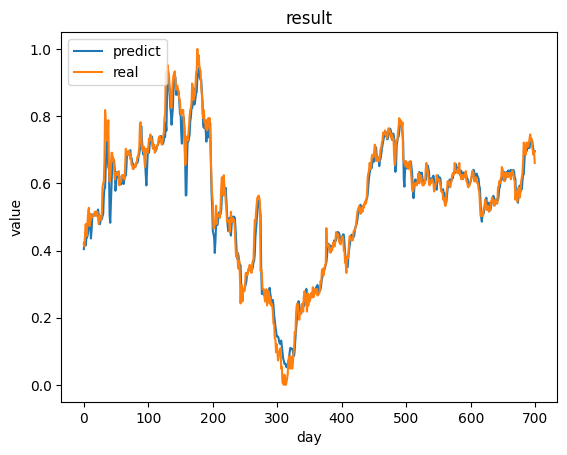

In [160]:
y_predicted = model.predict(x_test)
#預測
plt.plot(y_predicted)
#實際值
plt.plot(y_test)
#標題
plt.title('result')
#y軸標籤
plt.ylabel('value')
#x軸標籤
plt.xlabel('day')
#顯示折線的名稱
plt.legend(['predict', 'real'], loc='upper left')
#顯示折線圖
plt.show()

In [161]:
normalized_test_close_reshape = test_df['close'].values.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1)).fit(normalized_test_close_reshape)
actual_close = scaler.inverse_transform(y_test.reshape(-1, 1)).reshape(-1)
predicted_close = scaler.inverse_transform(y_predicted.reshape(-1, 1)).reshape(-1)

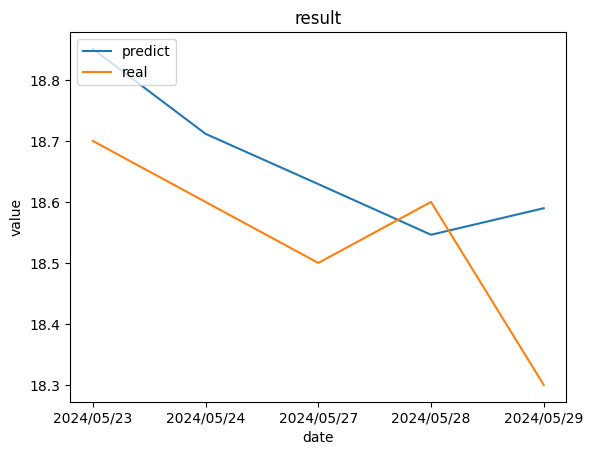

In [162]:
scale_x = [date.strftime("%Y/%m/%d") for date in df[len(df)-5:]['date'].values]
#預測
plt.plot(
    scale_x,
    predicted_close[len(predicted_close)-5:]
)
#實際值
plt.plot(
    scale_x,
    actual_close[len(actual_close)-5:]
)
#標題
plt.title('result')
#y軸標籤
plt.ylabel('value')
#x軸標籤
plt.xlabel('date')
#顯示折線的名稱
plt.legend(['predict', 'real'], loc='upper left')
#顯示折線圖
plt.show()

In [163]:
# 依據最後n天的數據預測隔天的收盤價
normalized_open_last_n_days = normalized_train_open[len(normalized_train_open)-n_days:]
normalized_close_last_n_days = normalized_train_close[len(normalized_train_open)-n_days:]
normalized_low_last_n_days = normalized_train_low[len(normalized_train_open)-n_days:]
normalized_high_last_n_days = normalized_train_high[len(normalized_train_open)-n_days:]
normalized_volume_last_n_days = normalized_train_volume[len(normalized_train_open)-n_days:]

data_last_n_days = []

for open, close, low, high, volume in zip(
    normalized_open_last_n_days,
    normalized_close_last_n_days,
    normalized_low_last_n_days,
    normalized_high_last_n_days,
    normalized_volume_last_n_days
):
    data_last_n_days.append([open, close, low, high, volume])

x_last_n_days = np.array([data_last_n_days])
y_predicted_tomorrow = model.predict(x_last_n_days)
normalized_train_close_reshape = train_df['close'].values.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1)).fit(normalized_train_close_reshape)
predicted_tomorrow_close = scaler.inverse_transform(y_predicted_tomorrow).reshape(-1)
print(predicted_tomorrow_close)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
[18.417753]


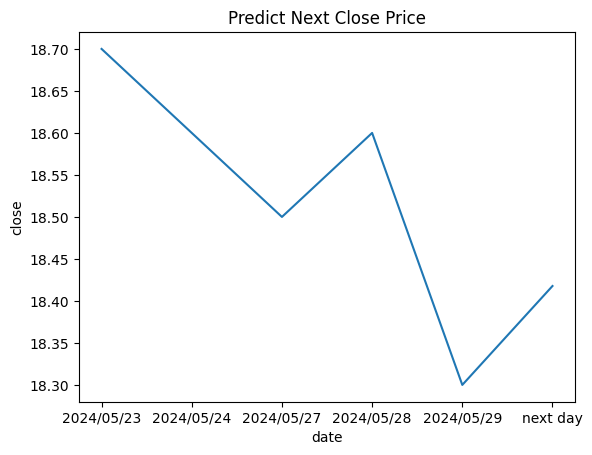

In [164]:
scale_x = [date.strftime("%Y/%m/%d") for date in df[len(df)-n_days:]['date'].values]
scale_x.append('next day')
scale_y = actual_close[len(actual_close)-n_days:].copy()
scale_y = np.append(scale_y, predicted_tomorrow_close)
plt.plot(
    scale_x,
    scale_y
)
#標題
plt.title('Predict Next Close Price')
#y軸標籤
plt.ylabel('close')
#x軸標籤
plt.xlabel('date')
#顯示折線圖
plt.show()